In [1]:
w_python = !which python
if 'home' in w_python[0]:
    resources_prefix = ''
else:
    !pip install watermark LightFM

    from google.colab import drive
    drive.mount('/content/drive')

    resources_prefix = '/content/drive/MyDrive/Machine Learning/Notebooks/0401_Recommender Systems - Movie/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 5.2 MB/s 
  Created wheel for LightFM: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705383 sha256=2e148a4beb2beee3fe15c635c4c09ff00a364c8154c2a25f2b510908cf15aa87
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built LightFM
Mounted at /content/drive


In [2]:
# !conda install -y watermark

In [3]:
%load_ext watermark
%watermark

Last updated: 2022-08-03T23:14:21.258290+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [4]:
import pandas as pd

import numpy as np

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer

from ast import literal_eval

from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix

from lightfm import LightFM

from ipywidgets import interact

import nltk  # Natural language toolkit

## Resume

The dataset files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. This dataset captures feature points like cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts, and vote averages.

These feature points could be potentially used to train your machine learning models for content and collaborative filtering.

This dataset consists of the following files:

- movies_metadata.csv: This file contains information on ~45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, genre, revenue, release dates, languages, production countries, and companies.
- keywords.csv: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.
- credits.csv: Consists of Cast and Crew Information for all the movies. Available in the form of a stringified JSON Object.
- links.csv: This file contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.
- links_small.csv: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.
- ratings_small.csv: The subset of 100,000 ratings from 700 users on 9,000 movies.

The Full MovieLens Dataset comprises of 26 million ratings and 750,000 tag applications, from 270,000 users on all the 45,000 movies in this dataset. It can be accessed from the official GroupLens website.

https://grouplens.org/datasets/movielens/latest/

Note: The subset dataset used in today's tutorial can be downloaded from: https://www.kaggle.com/rounakbanik/the-movies-dataset

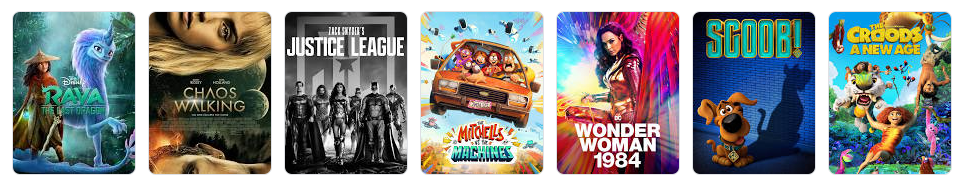

## Data Collection

In [5]:
sns.set_style("whitegrid")

In [6]:
item_df = pd.read_csv(f'{resources_prefix}_resources/movies_metadata.csv', low_memory=False)
# Remove rows with bad IDs.
item_df = item_df.drop([19730, 29503, 35587])

credits_df = pd.read_csv(f'{resources_prefix}_resources/credits.csv')

keywords_df = pd.read_csv(f'{resources_prefix}_resources/keywords.csv')

# Convert IDs to int. Required for merging
item_df['id'] = item_df.id.astype(np.int64)
credits_df['id'] = credits_df.id.astype(np.int64)
keywords_df['id'] = keywords_df.id.astype(np.int64)

item_df = item_df.merge(right=credits_df, on='id').merge(right=keywords_df, on='id')
item_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


## Data Wrangling

If multiple data sources are combined in the same dataset, the indexes must be reset.

In [7]:
item_df[item_df.index.duplicated()].count()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
cast                     0
crew                     0
keywords                 0
dtype: int64

In [8]:
item_df.reset_index(inplace=True, drop=True)

In [9]:
item_df[item_df.index.duplicated()].count()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
cast                     0
crew                     0
keywords                 0
dtype: int64

Data types are analyzed and corrected.

In [10]:
item_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
cast                      object
crew                      object
keywords                  object
dtype: object

In [11]:
item_df['budget'] = pd.to_numeric(arg=item_df.budget, errors='coerce')
item_df['popularity'] = pd.to_numeric(arg=item_df.popularity, errors='coerce')
item_df['release_date'] = pd.to_datetime(arg=item_df.release_date, errors='coerce')
item_df['original_language'] = item_df.original_language.astype(dtype='category')
item_df['status'] = item_df.status.astype(dtype='category')
item_df['video'] = item_df.video.astype(dtype='bool')

item_df.dtypes

adult                            object
belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
id                                int64
imdb_id                          object
original_language              category
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
revenue                         float64
runtime                         float64
spoken_languages                 object
status                         category
tagline                          object
title                            object
video                              bool
vote_average                    float64
vote_count                      float64
cast                             object


Complex data is updated with the most important data.

But first things first, your data is present in the form of "stringified" lists. You need to convert them into a way that is usable for you.

https://www.aipython.in/python-literal_eval/

In [12]:
def get_name(x):
    try:
        return literal_eval(x)['name']
    except:
        return np.nan


def get_crew(job, x):
    for i in literal_eval(x):
        if i['job'] == job:
            return i['name']
    return np.nan


# It is converted to lowercase without spaces to then build the columns.
def get_genre_list(x):
    try:
        names = [i['name'].lower().replace(' ', '_') for i in literal_eval(x)]
        return names
    except:
        return []


def get_name_list(x):
    try:
        names = [i['name'] for i in literal_eval(x)]
        return names
    except:
        return []


item_df['belongs_to_collection'] = item_df.belongs_to_collection.apply(get_name)
item_df['genres'] = item_df.genres.apply(get_genre_list)
item_df['production_companies'] = item_df.production_companies.apply(get_name_list)
item_df['production_countries'] = item_df.production_countries.apply(get_name_list)
item_df['spoken_languages'] = item_df.spoken_languages.apply(get_name_list)
item_df['cast'] = item_df.cast.apply(get_name_list)
item_df['director'] = item_df.crew.apply(lambda x: get_crew('Director', x))
item_df['producer'] = item_df.crew.apply(lambda x: get_crew('Producer', x))
item_df['keywords'] = item_df.keywords.apply(get_name_list)

item_df.drop(columns=['crew'], axis=1, inplace=True)

item_df[['belongs_to_collection', 'genres', 'production_companies', 'production_countries',
         'spoken_languages', 'cast', 'director', 'producer', 'keywords']].head()

,belongs_to_collection,genres,production_companies,production_countries,spoken_languages,cast,director,producer,keywords
0,Toy Story Collection,"[animation, comedy, family]",[Pixar Animation Studios],[United States of America],[English],"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,Bonnie Arnold,"[jealousy, toy, boy, friendship, friends, riva..."
1,NaN,"[adventure, fantasy, family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],"[English, Français]","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,Scott Kroopf,"[board game, disappearance, based on children'..."
2,Grumpy Old Men Collection,"[romance, comedy]","[Warner Bros., Lancaster Gate]",[United States of America],[English],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,NaN,"[fishing, best friend, duringcreditsstinger, o..."
3,NaN,"[comedy, drama, romance]",[Twentieth Century Fox Film Corporation],[United States of America],[English],"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,Ronald Bass,"[based on novel, interracial relationship, sin..."
4,Father of the Bride Collection,[comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America],[English],"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,Nancy Meyers,"[baby, midlife crisis, confidence, aging, daug..."


New columns from gender can be created, but as it is a recommendation system, where there is an infinity of information, it is not necessary to separate all the data encapsulated in lists into new columns because too many would be created.

We leave the following code for future problems.

In [13]:
# unique_genres = set(item_df.genres.sum())

# for col in unique_genres:
#     item_df[col] = 0

# for index, row in item_df.iterrows():
#     for genre in row.genres:
#         item_df.at[index, genre] = 1

# item_df.drop(columns=['genres'], axis=1, inplace=True)

# item_df[unique_genres].head()

The following function should be called whenever a column is added to or removed from the dataset.

In [14]:
def update_datatypes_columns():
    numeric_columns = item_df.select_dtypes(include=np.number).columns
    continuous_columns = item_df.select_dtypes(include=np.float64).columns
    discrete_columns = item_df.select_dtypes(include=np.int64).columns
    categorical_columns = item_df.select_dtypes(include='category').columns
    object_columns = item_df.select_dtypes(include='object').columns

    return numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns


numeric_columns, continuous_columns, discrete_columns, categorical_columns, object_columns = update_datatypes_columns()

## Data Cleaning

### Duplicate Records

The records that are identical in some of their columns are verified.

In [15]:
item_df.iloc[0]

adult                                                                False
belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [animation, comedy, family]
homepage                              http://toystory.disney.com/toy-story
id                                                                     862
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies                             [Pixar Animation Studios]
production_countries     

In [16]:
identical_columns = ['title', 'belongs_to_collection', 'homepage', 'imdb_id', 'original_title', 'overview']
item_df.duplicated(subset=identical_columns)

0        False
1        False
2        False
3        False
4        False
         ...  
46623    False
46624    False
46625    False
46626    False
46627    False
Length: 46628, dtype: bool

In [17]:
# Cuántos records están duplicados
duplicated = item_df[item_df.duplicated(subset=identical_columns)].shape
duplicated

(1196, 28)

View duplicate records.

In [18]:
item_df[item_df.duplicated(subset=identical_columns, keep=False)][identical_columns]

,title,belongs_to_collection,homepage,imdb_id,original_title,overview
676,The Promise,NaN,NaN,tt0111613,Das Versprechen,"East-Berlin, 1961, shortly after the erection ..."
677,The Promise,NaN,NaN,tt0111613,Das Versprechen,"East-Berlin, 1961, shortly after the erection ..."
678,The Promise,NaN,NaN,tt0111613,Das Versprechen,"East-Berlin, 1961, shortly after the erection ..."
679,The Promise,NaN,NaN,tt0111613,Das Versprechen,"East-Berlin, 1961, shortly after the erection ..."
680,The Promise,NaN,NaN,tt0111613,Das Versprechen,"East-Berlin, 1961, shortly after the erection ..."
...,...,...,...,...,...,...
37509,Trevor Noah: The Daywalker,NaN,http://www.trevornoah.com,tt1552639,Trevor Noah: The Daywalker,Trevor Noah Stand up comedy
37510,Perfect Body,NaN,NaN,tt0119881,Perfect Body,"Obsessed with perfection, young gymnast Andie ..."
37511,Perfect Body,NaN,NaN,tt0119881,Perfect Body,"Obsessed with perfection, young gymnast Andie ..."
37512,Ma L'Amore... Sì,NaN,NaN,tt0984996,Ma L'Amore... Sì,NaN


In [19]:
if duplicated[0] > 0:
    print('There are duplicate records.')
else:
    print('There are no duplicate records.')

There are duplicate records.


We use the pandas `drop_duplicates` function to remove duplicate records.

In [20]:
# Analizar luego por qué al elminar afecta los resultados obtenidos en 'Content Based'.
# item_df.drop_duplicates(subset=identical_columns, keep='first', inplace=True)
item_df.shape

(46628, 28)

### Cardinality

If a column has the same value always (> 90%), that column can be deleted.

In [21]:
n_records = len(item_df)


def duplicate_column_values(df):
    resume = pd.DataFrame(columns=['VARIABLE', 'LESS_COMMON', '% LESS_COMMON', 'MORE_COMMON', '% MORE_COMMON', 'DATA_TYPE'])

    # Uncomment when finished, it takes a long time.
#     for columna in df:
#         n_per_value = df[columna].value_counts()
#         more_common = n_per_value.iloc[0]
#         less_common = n_per_value.iloc[-1]

#         new_df = pd.DataFrame(data={'VARIABLE': [columna],
#                                     'LESS_COMMON': [less_common],
#                                     '% LESS_COMMON': [round(less_common * 100 / (1.0 * n_records), 3)],
#                                     'MORE_COMMON': [more_common],
#                                     '% MORE_COMMON': [round(more_common * 100 / (1.0 * n_records), 3)],
#                                     'DATA_TYPE': [df[columna].dtype]})

#         resume = pd.concat([resume, new_df], ignore_index=True)

    return resume


resume = duplicate_column_values(item_df)
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE


In [22]:
resume = resume.loc[resume['% MORE_COMMON'] > 90.]
resume

,VARIABLE,LESS_COMMON,% LESS_COMMON,MORE_COMMON,% MORE_COMMON,DATA_TYPE


In [23]:
if resume.loc[resume['% MORE_COMMON'] > 90.].size == 0:
    print('No field contains more than 90% of its data repeated.')
else:
    print('Some fields contain more than 90% of their data repeated. They must be removed.')

No field contains more than 90% of its data repeated.


The analysis is performed to eliminate or not the columns.

The columns will be removed.

In [24]:
item_df.drop(resume.VARIABLE, axis=1, inplace=True)

In [25]:
item_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,keywords,director,producer
0,False,Toy Story Collection,30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,Bonnie Arnold
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...",Joe Johnston,Scott Kroopf
2,False,Grumpy Old Men Collection,0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,NaN
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...",Forest Whitaker,Ronald Bass
4,False,Father of the Bride Collection,0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,Nancy Meyers


### Missing Values

Completely empty columns are removed.

In [26]:
item_df.dropna(axis=1, how='all', inplace=True)

Completely empty rows are removed.

In [27]:
item_df.dropna(axis=0, how='all', inplace=True)

# In case you want to delete the row if any of its values is missing, use 'any' in the 'how' parameter
# Use subset['col1', 'col2'] if you want to apply to some columns only.

#### Continuous Variables

Continuous variables are selected.

In [28]:
continuous_data = item_df[continuous_columns]
continuous_data.head()

,popularity,revenue,runtime,vote_average,vote_count
0,21.946943,373554033.0,81.0,7.7,5415.0
1,17.015539,262797249.0,104.0,6.9,2413.0
2,11.712900,0.0,101.0,6.5,92.0
3,3.859495,81452156.0,127.0,6.1,34.0
4,8.387519,76578911.0,106.0,5.7,173.0


In [29]:
# Casos con variables null
if continuous_data[continuous_data.isnull().any(axis=1)].shape[0] > 0:
    print('There are continuous variables with null value.')
else:
    print('There are no continuous variables with a null value.')

There are continuous variables with null value.


In [30]:
# Shows cases with null variables.
continuous_data[continuous_data.isnull().any(axis=1)]

,popularity,revenue,runtime,vote_average,vote_count
634,0.066123,0.0,NaN,4.0,1.0
635,0.002229,65335.0,NaN,0.0,0.0
644,0.439989,0.0,NaN,0.0,0.0
809,0.106345,0.0,NaN,4.0,1.0
877,0.437895,0.0,NaN,0.0,0.0
...,...,...,...,...,...
46409,0.002513,0.0,NaN,0.0,0.0
46472,0.030803,0.0,NaN,0.0,0.0
46475,0.000102,0.0,NaN,0.0,0.0
46539,0.006352,0.0,NaN,0.0,0.0


In [31]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')   # The mean is used

continuous_data_imp = imputer.fit_transform(continuous_data)
continuous_data_imp.shape   # Stores all values, not just imputed ones

(46628, 5)

In [32]:
# Convert to a dataframe
continuous_data_imp = pd.DataFrame(data=continuous_data_imp, index=continuous_data.index, columns=continuous_data.columns)

# Preserve datatypes
continuous_data_imp = continuous_data_imp.astype(continuous_data.dtypes.to_dict())

continuous_data_imp.head()

,popularity,revenue,runtime,vote_average,vote_count
0,21.946943,373554033.0,81.0,7.7,5415.0
1,17.015539,262797249.0,104.0,6.9,2413.0
2,11.712900,0.0,101.0,6.5,92.0
3,3.859495,81452156.0,127.0,6.1,34.0
4,8.387519,76578911.0,106.0,5.7,173.0


It verifies that there are no null values.

In [33]:
continuous_data_imp[continuous_data_imp.isnull().any(axis=1)].shape

(0, 5)

The original dataset is updated with the imputed values.

In [34]:
item_df.loc[:, continuous_data.columns] = continuous_data_imp
item_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,keywords,director,producer
0,False,Toy Story Collection,30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,Bonnie Arnold
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...",Joe Johnston,Scott Kroopf
2,False,Grumpy Old Men Collection,0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,NaN
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...",Forest Whitaker,Ronald Bass
4,False,Father of the Bride Collection,0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,Nancy Meyers


#### Discrete - Categorical Variables

Discrete or categorical variables are selected.

In [35]:
discrete_categorical_data = item_df[discrete_columns.union(categorical_columns)]
discrete_categorical_data.head()

,budget,id,original_language,status
0,30000000,862,en,Released
1,65000000,8844,en,Released
2,0,15602,en,Released
3,16000000,31357,en,Released
4,0,11862,en,Released


In [36]:
# Cases with null variables
if discrete_categorical_data[discrete_categorical_data.isnull().any(axis=1)].shape[0] > 0:
    print('There are discrete or categorical variables with a null value.')
else:
    print('There are no discrete or categorical variables with a null value.')

There are discrete or categorical variables with a null value.


In [37]:
# Show cases with null variables
discrete_categorical_data[discrete_categorical_data.isnull().any(axis=1)]

,budget,id,original_language,status
189,0,56088,en,NaN
774,0,52059,en,NaN
1405,0,40506,en,NaN
2160,0,77314,fr,NaN
3487,0,94214,en,NaN
...,...,...,...,...
45820,0,104473,NaN,Rumored
46230,0,49492,en,NaN
46253,0,128268,en,NaN
46322,0,41811,en,NaN


In [38]:
if discrete_categorical_data.columns.size > 0:
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')   # most_frequent is used

    discrete_categorical_imp = imputer.fit_transform(discrete_categorical_data)
    # Stores all values, not just imputed ones.
    print(discrete_categorical_imp.shape)
else:
    print('There are no discrete or categorical variables.')

(46628, 4)


In [39]:
if discrete_categorical_data.columns.size > 0:
    # Convert to a dataframe.
    discrete_categorical_imp = pd.DataFrame(data=discrete_categorical_imp, index=discrete_categorical_data.index, columns=discrete_categorical_data.columns)
    
    # Preserve datatypes
    discrete_categorical_imp = discrete_categorical_imp.astype(discrete_categorical_data.dtypes.to_dict())

    display(discrete_categorical_imp.head())
else:
    print('There are no discrete or categorical variables.')

,budget,id,original_language,status
0,30000000,862,en,Released
1,65000000,8844,en,Released
2,0,15602,en,Released
3,16000000,31357,en,Released
4,0,11862,en,Released


It verifies that there are no null values.

In [40]:
if discrete_categorical_data.columns.size > 0:
    print(discrete_categorical_imp[discrete_categorical_imp.isnull().any(axis=1)].shape)
else:
    print('There are no discrete or categorical variables.')

(0, 4)


The original dataset is updated with the imputed values.

In [41]:
if discrete_categorical_data.columns.size > 0:
    item_df.loc[:, discrete_categorical_data.columns] = discrete_categorical_imp
    display(item_df.head())
else:
    print('There are no discrete or categorical variables.')

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,keywords,director,producer
0,False,Toy Story Collection,30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Released,NaN,Toy Story,False,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,Bonnie Arnold
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...",Joe Johnston,Scott Kroopf
2,False,Grumpy Old Men Collection,0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,NaN
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...",Forest Whitaker,Ronald Bass
4,False,Father of the Bride Collection,0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,Nancy Meyers


## Machine Learning

### Top items (IMDb - Internet Movie database)

Calculate mean of vote average column.

In [42]:
C = item_df.vote_average.mean()
C

5.6117278654770075

Calculate the minimum number of votes required to be in the chart, m.

In [43]:
m = item_df.vote_count.quantile(q=0.90)
m

156.0

Filter out all qualified items into a new DataFrame.

In [44]:
q_items = item_df[['title', 'vote_count', 'vote_average']].copy().loc[item_df.vote_count >= m]

display(q_items.shape)
display(item_df.shape)

(4680, 3)

(46628, 28)

From the above output, it is clear that there are around 10% items with vote count more than 160 and qualify to be on this list.

Function that computes the weighted rating of each item.

In [45]:
def weighted_rating(x, m=m, C=C):
    v = x.vote_count
    R = x.vote_average

    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

Define a new feature 'score' and calculate its value with `weighted_rating()`.

In [46]:
q_items['score'] = q_items.apply(weighted_rating, axis=1)

Sort items based on score calculated above.

In [47]:
q_items = q_items.sort_values(by='score', ascending=False)

Print the top 20 items.

In [48]:
q_items.head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.447079
10397,Dilwale Dulhania Le Jayenge,661.0,9.1,8.433941
841,The Godfather,6024.0,8.5,8.427092
12589,The Dark Knight,12269.0,8.3,8.266248
2870,Fight Club,9678.0,8.3,8.257355
292,Pulp Fiction,8670.0,8.3,8.252485
522,Schindler's List,4436.0,8.3,8.208674
23868,Whiplash,4376.0,8.3,8.207465
5529,Spirited Away,3968.0,8.3,8.198310
2231,Life Is Beautiful,3643.0,8.3,8.189610


### Recommend items by item (TfidfVectorizer)

In [49]:
item_df.overview.head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [50]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
item_df['overview'] = item_df.overview.fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
# Only 20000, memory limit
tfidf_matrix = tfidf.fit_transform(item_df.overview[:20000])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(20000, 47306)

In [51]:
# Array mapping from feature integer indices to feature name.
tfidf.get_feature_names_out()[1000:1020]

array(['added', 'addendum', 'addict', 'addicted', 'addiction',
       'addictions', 'addictive', 'addicts', 'addie', 'adding',
       'addition', 'additional', 'additionally', 'addled', 'address',
       'addressed', 'addressee', 'addresses', 'addressing', 'adds'],
      dtype=object)

Compute the cosine similarity matrix. `linear_kernel` is the same as `cosine_similarity`.

In [52]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(20000, 20000)

In [53]:
cosine_sim[0:5]

array([[1.        , 0.01576037, 0.        , ..., 0.        , 0.        ,
        0.03243544],
       [0.01576037, 1.        , 0.04916743, ..., 0.02331808, 0.        ,
        0.        ],
       [0.        , 0.04916743, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02501823, ..., 0.        , 0.04945511,
        0.        ]])

In [54]:
# Construct a reverse map of indexs and items titles
items_idx = pd.Series(data=item_df.index, index=item_df.title).drop_duplicates()
items_idx.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

In [55]:
# Function that takes in item name as input and outputs most similar items
def recommend_items_by_item(title, cosine_sim, n):
    # Get the index of the item that matches the title
    idx = items_idx[title]

    # Get the pairwsie similarity scores of all items with that item
    sim_scores = enumerate(cosine_sim[idx])
    
    # Sort the items based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar items
    sim_scores = sim_scores[1:n+1]

    # Get the item indexs
    item_idxs = [i[0] for i in sim_scores]

    # Return the top 10 most similar items
    rec = pd.DataFrame(data=item_df[['title', 'id']].iloc[item_idxs])

    # Add scores
    rec['score'] = [i[1] for i in sim_scores]

    return rec


recommend_items_by_item(title='Rocky', cosine_sim=cosine_sim, n=10)

,title,id,score
2318,Rocky IV,1374,0.270173
11555,Rocky Balboa,1246,0.249809
2316,Rocky II,1367,0.247660
2319,Rocky V,1375,0.244858
2317,Rocky III,1371,0.211608
17492,The Prizefighter and the Lady,95854,0.175277
7949,Angels with Dirty Faces,13696,0.170540
15195,Cain and Mabel,184741,0.170095
10236,Somebody Up There Likes Me,28000,0.162961
16321,The Fighter,45317,0.161204


### Recommend items by item (CountVectorizer)

In [56]:
item_df.iloc[0]

adult                                                                False
belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [animation, comedy, family]
homepage                              http://toystory.disney.com/toy-story
id                                                                     862
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies                             [Pixar Animation Studios]
production_countries     

In [57]:
features = ['cast', 'keywords', 'director', 'genres', 'belongs_to_collection', 'original_title', 'production_companies']
item_df[features].head()

,cast,keywords,director,genres,belongs_to_collection,original_title,production_companies
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...",John Lasseter,"[animation, comedy, family]",Toy Story Collection,Toy Story,[Pixar Animation Studios]
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...",Joe Johnston,"[adventure, fantasy, family]",NaN,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co..."
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...",Howard Deutch,"[romance, comedy]",Grumpy Old Men Collection,Grumpier Old Men,"[Warner Bros., Lancaster Gate]"
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...",Forest Whitaker,"[comedy, drama, romance]",NaN,Waiting to Exhale,[Twentieth Century Fox Film Corporation]
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",Charles Shyer,[comedy],Father of the Bride Collection,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]"


In [58]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        # Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(' ', ''))
        else:
            return ''

In [59]:
for feature in features:
    item_df[feature] = item_df[feature].apply(clean_data)

item_df[features].head(10)

,cast,keywords,director,genres,belongs_to_collection,original_title,production_companies
0,"[tomhanks, timallen, donrickles, jimvarney, wa...","[jealousy, toy, boy, friendship, friends, riva...",johnlasseter,"[animation, comedy, family]",toystorycollection,toystory,[pixaranimationstudios]
1,"[robinwilliams, jonathanhyde, kirstendunst, br...","[boardgame, disappearance, basedonchildren'sbo...",joejohnston,"[adventure, fantasy, family]",,jumanji,"[tristarpictures, teitlerfilm, interscopecommu..."
2,"[waltermatthau, jacklemmon, ann-margret, sophi...","[fishing, bestfriend, duringcreditsstinger, ol...",howarddeutch,"[romance, comedy]",grumpyoldmencollection,grumpieroldmen,"[warnerbros., lancastergate]"
3,"[whitneyhouston, angelabassett, lorettadevine,...","[basedonnovel, interracialrelationship, single...",forestwhitaker,"[comedy, drama, romance]",,waitingtoexhale,[twentiethcenturyfoxfilmcorporation]
4,"[stevemartin, dianekeaton, martinshort, kimber...","[baby, midlifecrisis, confidence, aging, daugh...",charlesshyer,[comedy],fatherofthebridecollection,fatherofthebridepartii,"[sandollarproductions, touchstonepictures]"
5,"[alpacino, robertdeniro, valkilmer, jonvoight,...","[robbery, detective, bank, obsession, chase, s...",michaelmann,"[action, crime, drama, thriller]",,heat,"[regencyenterprises, forwardpass, warnerbros.]"
6,"[harrisonford, juliaormond, gregkinnear, angie...","[paris, brotherbrotherrelationship, chauffeur,...",sydneypollack,"[comedy, romance]",,sabrina,"[paramountpictures, scottrudinproductions, mir..."
7,"[jonathantaylorthomas, bradrenfro, rachaelleig...",[],peterhewitt,"[action, adventure, drama, family]",,tomandhuck,[waltdisneypictures]
8,"[jean-claudevandamme, powersboothe, dorianhare...","[terrorist, hostage, explosive, vicepresident]",peterhyams,"[action, adventure, thriller]",,suddendeath,"[universalpictures, imperialentertainment, sig..."
9,"[piercebrosnan, seanbean, izabellascorupco, fa...","[cuba, falselyaccused, secretidentity, compute...",martincampbell,"[adventure, action, thriller]",jamesbondcollection,goldeneye,"[unitedartists, eonproductions]"


In [60]:
def create_soup(x):
    return ' '.join(x['keywords']) + \
        ' ' + ' '.join(x['cast']) + \
        ' ' + x['director'] + \
        ' ' + ' '.join(x['genres']) + \
        ' ' + x['belongs_to_collection'] + \
        ' ' + x['original_title'] + \
        ' ' + ' '.join(x['production_companies'])

In [61]:
item_df['soup'] = item_df.apply(create_soup, axis=1)
item_df.soup.head().values

array(['jealousy toy boy friendship friends rivalry boynextdoor newtoy toycomestolife tomhanks timallen donrickles jimvarney wallaceshawn johnratzenberger anniepotts johnmorris erikvondetten lauriemetcalf r.leeermey sarahfreeman pennjillette johnlasseter animation comedy family toystorycollection toystory pixaranimationstudios',
       "boardgame disappearance basedonchildren'sbook newhome recluse giantinsect robinwilliams jonathanhyde kirstendunst bradleypierce bonniehunt bebeneuwirth davidalangrier patriciaclarkson adamhann-byrd laurabellbundy jameshandy gillianbarber brandonobray cyrusthiedeke garyjosephthorup leonardzola lloydberry malcolmstewart annabelkershaw darrylhenriques robyndriscoll peterbryant sarahgilson floricavlad junelion brendalockmuller joejohnston adventure fantasy family  jumanji tristarpictures teitlerfilm interscopecommunications",
       'fishing bestfriend duringcreditsstinger oldmen waltermatthau jacklemmon ann-margret sophialoren darylhannah burgessmeredith k

The next steps are the same as what you did with your plot description based recommender. One key difference is that you use the CountVectorizer() instead of TF-IDF. This is because you do not want to down-weight the actor/director's presence if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense to down-weight them in this context.

The major difference between CountVectorizer() and TF-IDF is the inverse document frequency (IDF) component which is present in later and not in the former.

In [62]:
count = CountVectorizer(stop_words='english')

# Only 20000, limit memory
count_matrix = count.fit_transform(item_df['soup'][:20000])

count_matrix.shape

(20000, 171976)

In [63]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.02865341, 0.04260143, ..., 0.        , 0.        ,
        0.04642383],
       [0.02865341, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04260143, 0.        , 1.        , ..., 0.        , 0.        ,
        0.11470787],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.0559017 ],
       [0.04642383, 0.        , 0.11470787, ..., 0.        , 0.0559017 ,
        1.        ]])

In [64]:
recommend_items_by_item(title='Rocky IV', cosine_sim=cosine_sim, n=10)

,title,id,score
2317,Rocky III,1371,0.464660
2316,Rocky II,1367,0.452267
2319,Rocky V,1375,0.311188
11555,Rocky Balboa,1246,0.292685
19662,The Rocky Saga: Going the Distance,81830,0.286039
1865,Rocky,1366,0.284901
5910,Fat City,16993,0.182818
8101,The Set-Up,17218,0.147828
12577,Downhill Racer,33166,0.146254
9923,Paradise Alley,23916,0.144841


### Recommend items by user (SVD)

In [65]:
ratings_df = pd.read_csv(f'{resources_prefix}_resources/ratings_small.csv')
ratings_df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'}, inplace=True)

ratings_df.head()

,user_id,item_id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Values are observed.

In [66]:
np.sort(ratings_df.rating.unique())

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

We see that this dataset has a list of scores (on a scale from 1 to 5) that each user has given to a item.

Let's turn it into an array of N users per d items.

In [67]:
interaction_df = ratings_df.pivot_table(values='rating', index='user_id', columns='item_id', aggfunc='mean', fill_value=0)

interaction_df

item_id,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [68]:
print(f'Tenemos {interaction_df.index.size} usuarios y {interaction_df.columns.size} películas. Como vemos en el dataset la mayor parte del mismo está vacía (ya que hay muchas más películas que los usuarios no han evaluado todas las peliculas que han visto)')

Tenemos 671 usuarios y 9066 películas. Como vemos en el dataset la mayor parte del mismo está vacía (ya que hay muchas más películas que los usuarios no han evaluado todas las peliculas que han visto)


Como hemos visto el método descompone una matriz en un producto de sus factores, descomponiendola en sus vectores y valores singulares. El resultado no és exactamente igual que la matriz original, ya que al extraer los valores singulares, se ha eliminado aquella información que no es fundamental al dataset.

- Se necesita una matriz sparse para usar svds. 
- Es necesario sustituir los null por 0 como se hizo al convertir la matriz con pivot_table.
- Los valores de la matriz debe ser de tipo float.

In [69]:
interaction_sparse = coo_matrix(interaction_df)
interaction_sparse

<671x9066 sparse matrix of type '<class 'numpy.float64'>'
	with 100004 stored elements in COOrdinate format>

El objetivo es obtener los `k vectores` que representan la mayor cantidad de información (datos más representativos) y eliminando el ruido. 

In [70]:
U, s, V = svds(A=interaction_sparse, k=10)

- U: vectores singulares izquierdos (Información más escencial de los items en las columnas)
- s: matriz diagonal
- V: vectores singulares derechos (Información más escencial de las variables)

In [71]:
display(U)
display(s)
display(V)

array([[-1.44526939e-03, -5.21338392e-03,  2.14212718e-03, ...,
         1.49846725e-03, -3.90537685e-03,  2.08497408e-03],
       [ 1.13441022e-02, -1.86007394e-02, -1.03510477e-02, ...,
        -6.63596276e-02, -6.51418470e-03,  1.83070824e-02],
       [ 3.56610298e-03,  2.36550697e-02, -1.56397312e-02, ...,
        -1.12356475e-02,  1.32623643e-02,  1.50911407e-02],
       ...,
       [-2.20908275e-03,  3.93198164e-03, -3.69670402e-03, ...,
         3.86733047e-05, -1.58302556e-03,  6.99980178e-03],
       [ 5.63886944e-03,  1.30507871e-02, -1.12155237e-04, ...,
        -1.50645996e-02,  1.12626170e-03,  1.27201885e-02],
       [-6.37757840e-03,  1.40025881e-02, -2.39546710e-02, ...,
        -3.24647253e-03,  1.91584071e-02,  4.02662085e-02]])

array([116.32873458, 118.74152381, 122.99256885, 136.81751883,
       145.23455301, 156.30956977, 162.47028777, 204.30617832,
       243.76943485, 517.58313979])

array([[ 1.88130162e-02,  8.54217528e-03,  3.80146066e-03, ...,
        -1.18215948e-04, -7.09295690e-05, -2.38136288e-02],
       [ 2.52741783e-02, -7.07321948e-03, -7.16503962e-03, ...,
         8.13433325e-04,  4.88059995e-04,  5.75903025e-03],
       [-6.36119034e-02, -3.81599907e-02, -6.11142680e-03, ...,
        -9.45745474e-05, -5.67447284e-05,  2.23955483e-04],
       ...,
       [-5.09072327e-02, -6.43081958e-02, -2.84398301e-02, ...,
        -6.24198136e-05, -3.74518881e-05,  9.31325318e-03],
       [ 3.52425907e-02,  1.52635806e-02, -5.63629358e-03, ...,
         2.54528542e-04,  1.52717125e-04, -3.94405929e-03],
       [ 7.89608026e-02,  3.21870213e-02,  1.28461428e-02, ...,
         6.10278612e-05,  3.66167167e-05,  1.64855666e-03]])

In [72]:
U.shape, s.shape, V.shape

((671, 10), (10,), (10, 9066))

Vemos que con `svds`, las matrices **U** y **V** no son cuadradas, sino que son una submatriz conteniendo los *k* primeros vectores singulares izquierdos y derechos. Tambien nos devuelve sigma como vector de valores singulares lo tenemos que convertir a una matriz diagonal.

Convertir el vector diagonal (s) a una matriz diagonal (agregar ceros) para poder hacer el producto matricial de **U**x**s**x**V**.

In [73]:
s_diag_matrix = np.diag(s)
display(s_diag_matrix.shape)
display(s_diag_matrix)

(10, 10)

array([[116.32873458,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        , 118.74152381,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 122.99256885,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 136.81751883,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        145.23455301,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 156.30956977,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

In [74]:
interaction_svd = U @ s_diag_matrix @ V
display(interaction_svd.shape)
display(interaction_svd)

(671, 9066)

array([[-7.15795687e-03, -7.48597600e-04,  1.89821255e-02, ...,
        -8.00229526e-04, -4.80137716e-04,  1.94798384e-03],
       [ 1.61824763e+00,  1.58116478e+00,  6.31735978e-01, ...,
        -3.83081099e-04, -2.29848659e-04,  2.10423901e-02],
       [ 1.11116423e+00,  4.10937350e-01,  8.69390583e-02, ...,
         3.70014034e-03,  2.22008420e-03, -2.80048130e-02],
       ...,
       [ 2.16037957e-01,  3.92657590e-02,  3.03210976e-02, ...,
        -3.10497612e-05, -1.86298567e-05, -1.90354189e-02],
       [ 7.99879958e-01,  3.36758029e-01,  1.13258038e-01, ...,
         1.35391470e-03,  8.12348822e-04, -2.51432266e-02],
       [ 2.28998620e+00,  3.77775351e-01,  2.75999028e-02, ...,
         5.88758410e-03,  3.53255046e-03, -8.64685479e-02]])

Se utilizan las columnas y los índices originales en el nuevo dataframe generado a partir del svd.

In [75]:
interaction_svd_df = pd.DataFrame(data=interaction_svd, columns=interaction_df.columns, index=interaction_df.index).round(1)
interaction_svd_df

item_id,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
2,1.6,1.6,0.6,0.2,0.6,1.2,0.6,0.1,0.3,1.9,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
3,1.1,0.4,0.1,0.0,0.1,0.4,0.1,0.0,0.0,0.4,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
4,2.4,1.2,0.6,0.1,0.2,0.4,0.6,-0.1,0.2,1.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.1,-0.0,-0.0,-0.0
5,1.5,0.8,0.3,0.1,0.8,0.1,0.5,0.1,0.0,0.5,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1.1,1.1,0.5,0.1,0.4,1.2,0.4,0.1,0.3,1.5,...,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
668,0.3,0.0,0.0,0.0,-0.0,0.3,-0.0,0.0,0.0,0.1,...,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
669,0.2,0.0,0.0,0.0,0.0,0.1,0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


Vemos que pese a que se ha perdido la escala de los datos (no están en una escala de 1 a 5, se ha "rellenado" la matriz.

In [76]:
np.sort(np.unique(interaction_svd_df.values))

array([-3.4, -2.9, -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. ,
       -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9,
       -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,
        0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,
        1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,
        2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,
        3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,
        4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,
        5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,
        6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,
        8. ,  8.1,  8.2,  8.3,  8.7,  8.8])

Ahora tenemos una matriz con las "puntuaciones" que cada cliente daria a cada producto. Lo que tenemos que hacer es crear una funcion que dado un cliente, tome la fila que le corresponde en la matriz que hemos calculado con SVD. Para dicha fila, aquellos valores más altos serán aquellos con una puntuacion estimada más alta para dicho usuario. Asi que simplemente tomamos los productos (las columnas) con valores más altos **que no estuviesen en el dataset original para el usuario!**, ya que no le debemos recomendar productos que ya ha comprado, sino productos nuevos.

In [77]:
def recommend_items_by_user(interaction_pred_df, interaction_df, user_id, n_items=10):
    new_items_df = pd.DataFrame({'new_score': interaction_pred_df.loc[user_id], 'old_score': interaction_df.loc[user_id]})
    # Se eliminan los items antiguos.
    old_items_df = new_items_df[new_items_df.old_score > 0]
    new_items_df.drop(old_items_df.index, inplace=True)

    # Se obtienen los items antiguos en item_df.
    old_df = item_df[item_df.id.isin(old_items_df.index)]
    old_df = old_df.merge(right=old_items_df, how='inner', left_on='id', right_index=True)
    old_df = old_df.sort_values(by='old_score', ascending=False)
    old_df.set_index(keys='id', inplace=True)
    old_df = old_df[['title', 'genres', 'cast', 'old_score']]

    # Se retornan las n recomendaciones con más raitings.
    new_items_df.sort_values(by='new_score', ascending=False, inplace=True)
    new_items_df = new_items_df[:n_items][['new_score']]

    new_items_df = new_items_df.merge(right=item_df, how='inner', left_on='item_id', right_index=True)

    new_items_df = new_items_df[['title', 'genres', 'cast', 'new_score']]

    return new_items_df, old_df


new_items_df, old_items_df = recommend_items_by_user(interaction_svd_df, interaction_df, user_id=200, n_items=20)
print('New items:')
display(new_items_df)

print('Old items:')
display(old_items_df.head(20))

New items:


,title,genres,cast,new_score
item_id,,,,
4993,Rare Birds,"[comedy, drama, mystery, romance]","[williamhurt, mollyparker, gregmalone, andyjones]",3.6
5952,The American Friend,"[drama, thriller]","[dennishopper, brunoganz, lisakreuzer, gérardb...",3.4
7153,The Last Tycoon,"[drama, romance]","[robertdeniro, tonycurtis, robertmitchum, jean...",3.4
318,Swimming with Sharks,"[crime, comedy]","[kevinspacey, frankwhaley, michelleforbes, ben...",3.0
3578,Benji the Hunted,"[action, adventure, family]","[redsteagall, frankinn, nancyfrancis]",2.6
260,L'Enfer,"[crime, drama]","[emmanuellebéart, françoiscluzet, nathaliecard...",2.3
33794,The Decline of Western Civilization Part III,[documentary],"[rickwilder, flea, stephenchambers, garyfredo]",2.2
1704,Sphere,[science_fiction],"[dustinhoffman, sharonstone, samuell.jackson, ...",2.1
589,Pinocchio,"[animation, family]","[melblanc, donbrodie, waltercatlett, mariondar...",1.9


Old items:


,title,genres,cast,old_score
id,,,,
1682,Mothra vs. Godzilla,"[fantasy, science_fiction, action, adventure]","[akiratakarada, yurikohoshi, hiroshikoizumi, y...",5.0
36529,Metamorphosis,"[horror, science_fiction]","[genelebrock, catherinebaranov, harrycason, da...",5.0
1265,Bridge to Terabithia,"[adventure, drama, family]","[joshhutcherson, annasophiarobb, robertpatrick...",4.5
2011,Persepolis,"[animation, drama]","[chiaramastroianni, danielledarrieux, catherin...",4.5
527,Once Were Warriors,[drama],"[renaowen, temueramorrison, mamaengaroakerr-be...",4.5
2470,Belle Époque,"[comedy, drama, romance]","[penélopecruz, gabinodiego, ariadnagil, fernan...",4.5
49530,In Time,"[action, thriller, science_fiction]","[justintimberlake, amandaseyfried, cillianmurp...",4.5
293,A River Runs Through It,[drama],"[bradpitt, craigsheffer, tomskerritt, brendabl...",4.5
4995,Boogie Nights,[drama],"[markwahlberg, burtreynolds, johnc.reilly, jul...",4.5


### Recommend items by user (LightFM)

In [78]:
fm_model = LightFM(no_components=30, loss='warp', k=10)
fm_model.fit(interactions=interaction_sparse, epochs=100, num_threads=4, verbose=True)

Epoch: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


In [79]:
# Se obtienen todas las posiciones de los items.
items_pos = np.arange(interaction_df.shape[1])  # 0->n-1

# Se obtienen las predicciones de todos los usuarios para obtener una matriz parecida a interaction_svd_df.
interaction_fm = []

for index, user_id in list(enumerate(interaction_df.index)):
    # Predict: user_ids->pos   item_ids->pos
    # Se predice a partir de posiciones, no de identificadores.
    scores = fm_model.predict(user_ids=index, item_ids=items_pos)
    interaction_fm.append(scores)

interaction_fm_df = pd.DataFrame(data=interaction_fm, columns=interaction_svd_df.columns, index=interaction_svd_df.index)
interaction_fm_df

item_id,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.588302,-2.152651,-2.768092,-3.467146,-3.032085,-1.007455,-2.851463,-4.276317,-2.976500,-1.455779,...,-4.008680,-4.305669,-3.553102,-4.154686,-4.586803,-4.480929,-3.761762,-4.659150,-4.980070,-3.989577
2,-0.097038,0.101309,-1.511806,-1.543761,-0.403908,-0.702651,-0.937897,-2.382505,-1.821908,0.603115,...,-4.579053,-5.803497,-5.694112,-6.017768,-5.870428,-5.465040,-5.732768,-5.758755,-6.657102,-5.053978
3,-0.774741,-2.729804,-3.411354,-4.269030,-2.889796,-2.216398,-5.006165,-5.871820,-4.852694,-3.034141,...,-6.771796,-6.359162,-5.740176,-7.222821,-6.738782,-5.673734,-5.988780,-6.086783,-6.232300,-6.675472
4,-4.779806,-5.462207,-7.907811,-8.053359,-7.676282,-7.230804,-7.238545,-9.787938,-8.463094,-5.370640,...,-10.519608,-9.793437,-10.645367,-9.507084,-9.567836,-10.318844,-10.015243,-12.675504,-12.971287,-10.744617
5,-1.233254,-2.225985,-3.080225,-5.629507,-3.721496,-4.599164,-4.563379,-5.213802,-6.590377,-3.749005,...,-8.045581,-7.617507,-7.421952,-7.245484,-7.481291,-7.546385,-6.805928,-7.432432,-6.721197,-7.806111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,-0.352375,-0.939155,-1.613057,-1.256643,-0.887792,-0.568043,-0.762242,-2.462100,-1.764172,-0.277109,...,-4.428234,-5.453101,-5.644372,-6.150821,-5.746978,-5.859864,-5.653984,-5.354729,-6.145501,-4.528045
668,-0.730364,-2.624732,-2.287057,-3.055715,-2.160153,-1.859337,-2.283672,-3.825137,-3.659692,-2.621164,...,-3.950327,-4.326631,-4.941441,-4.482706,-4.335320,-4.679356,-4.527027,-4.745853,-4.613203,-3.985835
669,-2.194854,-4.792881,-3.203619,-4.018355,-3.842774,-2.672364,-4.842685,-4.393727,-4.363816,-4.582864,...,-5.784085,-4.334755,-5.265244,-5.449360,-5.565690,-5.011243,-5.198563,-5.999789,-5.822463,-5.543697


In [80]:
new_items_df, old_items_df = recommend_items_by_user(interaction_fm_df, interaction_df, user_id=200, n_items=20)
print('New items:')
display(new_items_df)

print('Old items:')
display(old_items_df.head(20))

New items:


,title,genres,cast,new_score
item_id,,,,
4993,Rare Birds,"[comedy, drama, mystery, romance]","[williamhurt, mollyparker, gregmalone, andyjones]",-4.295086
7153,The Last Tycoon,"[drama, romance]","[robertdeniro, tonycurtis, robertmitchum, jean...",-5.021369
5952,The American Friend,"[drama, thriller]","[dennishopper, brunoganz, lisakreuzer, gérardb...",-5.258114
5459,The Unearthly,"[science_fiction, horror]","[johncarradine, myronhealey, allisonhayes, mar...",-5.473527
457,A Good Man in Africa,"[comedy, drama]","[colinfriels, seanconnery, johnlithgow, dianar...",-5.803833
8972,Nobody's Fool,"[comedy, drama, romance]","[rosannaarquette, ericroberts, marewinningham,...",-5.819479
165,First Knight,"[action, adventure, drama, romance]","[seanconnery, richardgere, juliaormond, bencro...",-5.822376
733,Brothers in Trouble,"[comedy, drama]","[ompuri, angelineball, acebhatti, bhaskerpatel...",-5.844086
1608,Hugo Pool,"[comedy, romance]","[alyssamilano, markboonejunior, malcolmmcdowel...",-6.038778


Old items:


,title,genres,cast,old_score
id,,,,
1682,Mothra vs. Godzilla,"[fantasy, science_fiction, action, adventure]","[akiratakarada, yurikohoshi, hiroshikoizumi, y...",5.0
36529,Metamorphosis,"[horror, science_fiction]","[genelebrock, catherinebaranov, harrycason, da...",5.0
1265,Bridge to Terabithia,"[adventure, drama, family]","[joshhutcherson, annasophiarobb, robertpatrick...",4.5
2011,Persepolis,"[animation, drama]","[chiaramastroianni, danielledarrieux, catherin...",4.5
527,Once Were Warriors,[drama],"[renaowen, temueramorrison, mamaengaroakerr-be...",4.5
2470,Belle Époque,"[comedy, drama, romance]","[penélopecruz, gabinodiego, ariadnagil, fernan...",4.5
49530,In Time,"[action, thriller, science_fiction]","[justintimberlake, amandaseyfried, cillianmurp...",4.5
293,A River Runs Through It,[drama],"[bradpitt, craigsheffer, tomskerritt, brendabl...",4.5
4995,Boogie Nights,[drama],"[markwahlberg, burtreynolds, johnc.reilly, jul...",4.5


### Recommend users by item (SVD)

In [81]:
def recommend_users_by_item(interaction_pred_df, interaction_df, item_id, n_items=10):
    user_df = pd.DataFrame(data=interaction_pred_df[item_id])
    user_df.rename(columns={item_id: 'score'}, inplace=True)

    # Se eliminan los usuarios antiguos.
    old_users_idx = interaction_df[interaction_df[item_id] > 0].index.values
    user_df.drop(old_users_idx, inplace=True)

    return user_df.sort_values(by='score', ascending=False).head(n_items)


recommend_users_by_item(interaction_svd_df, interaction_df, item_id=22, n_items=10)

,score
user_id,
30,2.4
73,1.9
306,1.8
110,1.4
596,1.2
514,1.1
161,1.1
624,1.1
92,1.1


### Recommend users by item (LightFM)

In this use case, we will discuss how we can recommend a list of users specific to a particular item. Example of such cases is when you are running a promotion on an item and want to run an e-mail campaign around this promotional item to only 10,000 users who might be interested in this item.

In [83]:
recommend_users_by_item(interaction_fm_df, interaction_df, item_id=22, n_items=10)

,score
user_id,
495,1.393485
568,1.333001
151,1.292247
369,1.259534
50,1.227295
375,1.175629
191,1.099761
144,1.092545
415,1.072785
